Imports

In [3]:
import mbvam
from math import pi
import numpy as np
import matplotlib.pyplot as plt
#matplotlib qt
import torch
import mbvam.Geometry.visualize
import os.path
from PIL import Image
import copy
from scipy.ndimage import zoom

Setup

In [4]:
beam_config_1 = mbvam.Beam.holobeamconfig.HoloBeamConfig()
beam_config_1.binningFactor = 1
beam_config_1.Nx_physical = 1600
beam_config_1.Ny_physical = 1200
beam_config_1.axis_angle = [1,0,00]
beam_config_1.focal_SLM = 0.016 #0.012625 #------------------------------------------------------FILL THIS IN----------------------------------------------------------
assert beam_config_1.focal_SLM is not False, 'Effective Focal length needs to be set. It is 0.016 for original beam path.'

print(f'beam_config_1.fov: {beam_config_1.fov}')
print(f'Field of view in x = {beam_config_1.fov[0]}')
print(f'Field of view in y = {beam_config_1.fov[1]}')
print(f'{beam_config_1.abbe_res_x=}')
print(f'{beam_config_1.abbe_res_y=}')

# Use Gaussian profile
beam_config_1.amplitude_profile_type = 'gaussian' #'flat_top'
beam_config_1.gaussian_beam_waist = 0.0063188 #[m], measured beam waist of the Gaussian beam. Blue: 0.0063188. UV: 0.0038708. Ignored for flat top.


beam_config_2 = copy.deepcopy(beam_config_1)
beam_config_2.lambda_ = 0.365e-6  #[m], Wavelength of the light
beam_config_2.gaussian_beam_waist = 0.0038708 #[m], measured beam waist of the Gaussian beam. Blue: 0.0063188. UV: 0.0038708. Ignored for flat top.
beam_config_2.focal_SLM = 0.02 #------------------------------------------------------FILL THIS IN----------------------------------------------------------
assert beam_config_2.focal_SLM is not False, 'Effective Focal length needs to be set. It is 0.020 for original beam path.'

optim_config = mbvam.Optim.optimizationconfig.OptimizationConfig()
#optim_config.target_file_path = r'G:\My Drive\CITL for 3DHL\2D Images for Generating Phase Mask\square50_offset.png' 
optim_config.target_domain_size = tuple(ds/beam_config_1.binningFactor for ds in optim_config.target_domain_size)
optim_config.target_rotation = beam_config_1.axis_angle #[0, 0, 1, pi/4]

beam_config_1.fov: [0.00101887 0.00098765 0.00101887]
Field of view in x = 0.0010188731815098484
Field of view in y = 0.0009876529957429379
beam_config_1.abbe_res_x=np.float64(6.367957384436552e-07)
beam_config_1.abbe_res_y=np.float64(8.23044163119115e-07)


In [5]:
#Initialize the beam object
beam_1 = mbvam.Beam.holobeam.HoloBeam(beam_config_1)

beam_1.phase_mask_iter = torch.zeros((beam_config_1.Nx,beam_config_1.Ny), device=beam_config_1.device)
beam_1.slm_amplitude_profile = beam_1.buildSLMAmplitudeProfile()

beam_1.beam_mean_amplitude_iter = torch.tensor(1.0, device=beam_config_1.device, dtype=beam_config_1.fdtype)

In [6]:
#Initialize the beam object
beam_2 = mbvam.Beam.holobeam.HoloBeam(beam_config_2)

beam_2.phase_mask_iter = torch.zeros((beam_config_2.Nx,beam_config_2.Ny), device=beam_config_2.device)
beam_2.slm_amplitude_profile = beam_2.buildSLMAmplitudeProfile()

beam_2.beam_mean_amplitude_iter = torch.tensor(1.0, device=beam_config_2.device, dtype=beam_config_2.fdtype)

Import target for beam 1

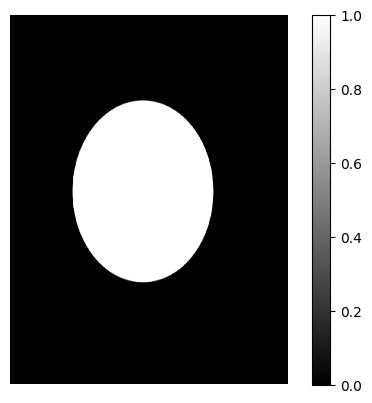

In [7]:
# Load the image
#image = Image.open(r"G:\Shared drives\taylorlab\3DHL\Phase masks\contrast_debug_masks\target\Line.png")
#image = Image.open(r"G:\내 드라이브\CITL for 3DHL\2D Images for Generating Phase Mask\square50_offset.png")
image = Image.open(r"C:\Users\cowgr\Documents\PhD\Research\REVAMP\Holographic\3DHL\CITL_Experiment\Experiment_Data\01222026\dot2.png")

# Convert the image to grayscale
image = image.convert("L")

# Define the original pixel size and the desired pixel size
original_pixel_size = 2e-6  # [m] Assuming 1.0 for both x and y in the original image. THIS IS INPUT by user
desired_pixel_size = (beam_config_1.abbe_res_x, beam_config_1.abbe_res_y)  # Different pixel sizes for x and y. UPDATE THIS LINE FOR BEAM_2

# Define the desired resolution (number of pixels)
desired_resolution = (beam_1.beam_config.Nx, beam_1.beam_config.Ny)  # Desired width and height in pixels

# Calculate the scaling factors for both x and y based on pixel size
original_width, original_height = image.size
scaling_factor_x = original_pixel_size / desired_pixel_size[0]
scaling_factor_y = original_pixel_size / desired_pixel_size[1]

# Convert the image to a numpy array
image_array = np.array(image)

# Apply zoom to adjust the resolution with interpolation
rescaled_image = zoom(image_array, (scaling_factor_y, scaling_factor_x), order=1)  # Linear interpolation (order=1)

target_w, target_h = desired_resolution 
cur_h, cur_w = rescaled_image.shape

final_image = np.zeros((target_h, target_w), dtype=rescaled_image.dtype)

offset_y = (target_h - cur_h) // 2
offset_x = (target_w - cur_w) // 2

dst_y_start = max(0, offset_y)
dst_x_start = max(0, offset_x)

src_y_start = max(0, -offset_y)
src_x_start = max(0, -offset_x)

copy_h = min(cur_h - src_y_start, target_h - dst_y_start)
copy_w = min(cur_w - src_x_start, target_w - dst_x_start)

if copy_h > 0 and copy_w > 0:
    final_image[dst_y_start : dst_y_start + copy_h, 
                dst_x_start : dst_x_start + copy_w] = \
    rescaled_image[src_y_start : src_y_start + copy_h, 
                   src_x_start : src_x_start + copy_w]

rescaled_image = final_image

#if rescaled_image.shape[0] > desired_resolution[1] or rescaled_image.shape[1] > desired_resolution[0]:
#    clip_height = rescaled_image.shape[0] - desired_resolution[1]
#    clip_width = rescaled_image.shape[1] - desired_resolution[0]
#    
#    # Symmetric clipping
#    clip_top = clip_height // 2
#    clip_bottom = clip_height - clip_top
#    clip_left = clip_width // 2
#    clip_right = clip_width - clip_left
#    
#    rescaled_image = rescaled_image[clip_top:rescaled_image.shape[0] - clip_bottom, clip_left:rescaled_image.shape[1] - clip_right]
#
## If the image is smaller than the desired resolution, zero-pad it
#elif rescaled_image.shape[0] < desired_resolution[1] or rescaled_image.shape[1] < desired_resolution[0]:
#    pad_height = desired_resolution[1] - rescaled_image.shape[0]
#    pad_width = desired_resolution[0] - rescaled_image.shape[1]
#    # rescaled_image = np.pad(rescaled_image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
#
#    # Symmetric padding
#    pad_top = pad_height // 2
#    pad_bottom = pad_height - pad_top
#    pad_left = pad_width // 2
#    pad_right = pad_width - pad_left
#    
#    rescaled_image = np.pad(rescaled_image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)


# Normalize the pixel values to range from 0 to 1
rescaled_image = rescaled_image.T / 255.0

# Display the image

fig, ax = plt.subplots()

# Display the image
cax = ax.imshow(rescaled_image, cmap="gray", interpolation='nearest')
ax.set_aspect('equal', adjustable='box') # Set the aspect ratio to 1:1
plt.colorbar(cax)
plt.axis("off")
plt.show()

Prepare inputs

In [8]:
image_tensor = torch.as_tensor(rescaled_image, device=beam_config_1.device, dtype=beam_config_1.fdtype)
image_tensor = torch.atleast_3d(image_tensor)
zv = torch.as_tensor(0.0, device=beam_config_1.device, dtype=beam_config_1.fdtype)

GS

In [ ]:
phase = beam_1.gerchbergsaxton(image_tensor,H=beam_1.buildEffectiveTF(z_query=zv),iterations=1000)

100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


Get volume recon

In [10]:
#Check reconstruction
beam_1.beam_config.z_plane_sampling_rate=0.5
beam_1.H = beam_1.buildEffectiveTF()
beam_1.beam_mean_amplitude_iter = torch.tensor(1.0, device=beam_config_1.device, dtype=beam_config_1.fdtype)
beam_1.phase_mask_iter = phase
recon = beam_1.propagateToVolume()

recon_np = recon.to('cpu').numpy()
recon_intensity_np = np.abs(recon_np)**2
print(recon_intensity_np.shape[2])

74


Visualization

In [11]:
mbvam.Geometry.visualize.openCVSliceViewer(recon_intensity_np) #Press q to quit the app.

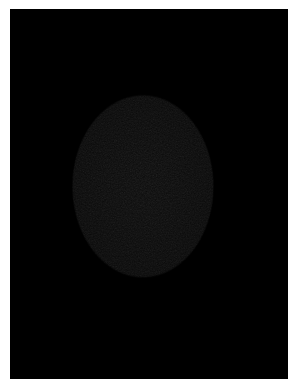

In [11]:
#save_directory = r'G:\내 드라이브\CITL for 3DHL\2D Images for Generating Phase Mask\square50_offset_aironly_obp_phase_mask'
save_directory = r'C:\Users\cowgr\Documents\PhD\Research\REVAMP\Holographic\3DHL\holovam\mbvam\Beam'
os.makedirs(save_directory, exist_ok=True)
recon_intensity_focal = recon_intensity_np[:,:,int(recon_intensity_np.shape[2]/2)]
recon_intensity_focal_mod = recon_intensity_focal.T
recon_intensity_focal_for_train = zoom(recon_intensity_focal_mod, (1/scaling_factor_y, 1/scaling_factor_x), order=1)
plt.imsave(save_directory+'\\focal_point_intensity_blue.png', recon_intensity_focal_for_train, cmap='gray')
plt.imshow(recon_intensity_focal, cmap="gray")
plt.axis("off")
plt.show()

Export Phase mask for blue

In [108]:
# save_directory = r'G:\Shared drives\taylorlab\CAL Projects\3DHL\Phase masks\contrast_debug_masks\GS_Lenna'
#save_directory = r'G:\내 드라이브\CITL for 3DHL\2D Images for Generating Phase Mask\square50_offset_aironly_phase_mask'

Export phase mask max = 1023
Export phase mask min = 0


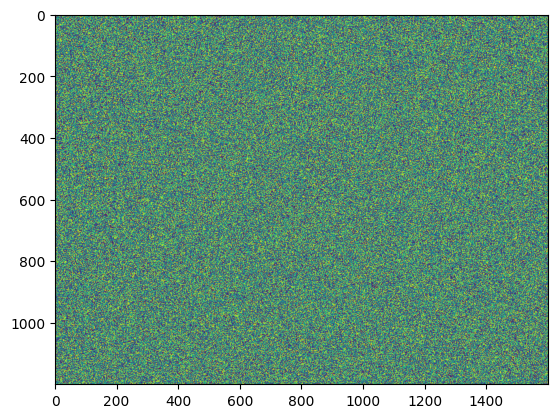

Saved test phase masks at C:\Users\cowgr\Documents\PhD\Research\REVAMP\Holographic\3DHL\holovam\mbvam\Beam


In [ ]:
phase_mask_test = phase%(2*torch.pi)
phase_mask_test *= 1023/(2*torch.pi)
phase_mask_test = torch.round(phase_mask_test).to(torch.int16)
phase_mask_test = phase_mask_test.T
print(f'Export phase mask max = {phase_mask_test.max()}')
print(f'Export phase mask min = {phase_mask_test.min()}')

#Display masks
fig, ax = plt.subplots(1,1)
ax.imshow(phase_mask_test.cpu().detach().numpy())
plt.savefig(save_directory+'\phase_mask_blue.png', dpi=150)
plt.show()


if not os.path.isdir(save_directory):
    os.makedirs(save_directory)
    print(f'Creating saving directory at {save_directory}')


np.save(os.path.join(save_directory,'phase_mask_blue.npy'), phase_mask_test.cpu().detach().numpy())
np.save(os.path.join(save_directory,'slm_phase.npy'), phase.cpu().detach().numpy())

print(f'Saved test phase masks at {save_directory}')

Import target for beam 2

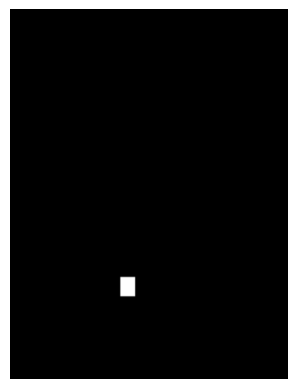

In [110]:
# Load the image
#image = Image.open(r"G:\내 드라이브\CITL for 3DHL\2D Images for Generating Phase Mask\dot50_offset.png")

# Convert the image to grayscale
image = image.convert("L")

# Define the original pixel size and the desired pixel size
original_pixel_size = 2e-6  # [m] Assuming 1.0 for both x and y in the original image. THIS IS INPUT by user
desired_pixel_size = (beam_config_2.abbe_res_x, beam_config_2.abbe_res_y)  # Different pixel sizes for x and y. UPDATE THIS LINE FOR BEAM_2

# Define the desired resolution (number of pixels)
desired_resolution = (beam_2.beam_config.Nx, beam_2.beam_config.Ny)  # Desired width and height in pixels

# Calculate the scaling factors for both x and y based on pixel size
original_width, original_height = image.size
scaling_factor_x = original_pixel_size / desired_pixel_size[0]
scaling_factor_y = original_pixel_size / desired_pixel_size[1]

# Convert the image to a numpy array
image_array = np.array(image)
# Apply zoom to adjust the resolution with interpolation
rescaled_image = zoom(image_array, (scaling_factor_y, scaling_factor_x), order=1)  # Linear interpolation (order=1)

target_w, target_h = desired_resolution 
cur_h, cur_w = rescaled_image.shape

final_image = np.zeros((target_h, target_w), dtype=rescaled_image.dtype)

offset_y = (target_h - cur_h) // 2
offset_x = (target_w - cur_w) // 2

dst_y_start = max(0, offset_y)
dst_x_start = max(0, offset_x)

src_y_start = max(0, -offset_y)
src_x_start = max(0, -offset_x)

copy_h = min(cur_h - src_y_start, target_h - dst_y_start)
copy_w = min(cur_w - src_x_start, target_w - dst_x_start)

if copy_h > 0 and copy_w > 0:
    final_image[dst_y_start : dst_y_start + copy_h, 
                dst_x_start : dst_x_start + copy_w] = \
    rescaled_image[src_y_start : src_y_start + copy_h, 
                   src_x_start : src_x_start + copy_w]

rescaled_image = final_image

# If the image is larger than the desired resolution, clip it
#if rescaled_image.shape[0] > desired_resolution[1] or rescaled_image.shape[1] > desired_resolution[0]:
#    clip_height = rescaled_image.shape[0] - desired_resolution[1]
#    clip_width = rescaled_image.shape[1] - desired_resolution[0]
#    
#    # Symmetric clipping
#    clip_top = clip_height // 2
#    clip_bottom = clip_height - clip_top
#    clip_left = clip_width // 2
#    clip_right = clip_width - clip_left
#    
#    rescaled_image = rescaled_image[clip_top:rescaled_image.shape[0] - clip_bottom, clip_left:rescaled_image.shape[1] - clip_right]
#
## If the image is smaller than the desired resolution, zero-pad it
#elif rescaled_image.shape[0] < desired_resolution[1] or rescaled_image.shape[1] < desired_resolution[0]:
#    pad_height = desired_resolution[1] - rescaled_image.shape[0]
#    pad_width = desired_resolution[0] - rescaled_image.shape[1]
#    # rescaled_image = np.pad(rescaled_image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
#
#    # Symmetric padding
#    pad_top = pad_height // 2
#    pad_bottom = pad_height - pad_top
#    pad_left = pad_width // 2
#    pad_right = pad_width - pad_left
#    
#    rescaled_image = np.pad(rescaled_image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)


# Normalize the pixel values to range from 0 to 1
rescaled_image = rescaled_image.T / 255.0

# Display the image
plt.imshow(rescaled_image, cmap="gray")
plt.axis("off")
plt.show()

Optimize for beam 2

In [111]:
image_tensor = torch.as_tensor(rescaled_image, device=beam_config_2.device, dtype=beam_config_2.fdtype)
image_tensor = torch.atleast_3d(image_tensor)
zv = torch.as_tensor(0.0, device=beam_config_2.device, dtype=beam_config_2.fdtype)

In [112]:
phase = beam_2.gerchbergsaxton(image_tensor,H=beam_2.buildEffectiveTF(z_query=zv),iterations=1000)

100%|██████████| 1000/1000 [00:47<00:00, 20.90it/s]


In [113]:
#Check reconstruction
beam_2.beam_config.z_plane_sampling_rate=0.5
beam_2.H = beam_2.buildEffectiveTF()
beam_2.beam_mean_amplitude_iter = torch.tensor(1.0, device=beam_config_2.device, dtype=beam_config_2.fdtype)
beam_2.phase_mask_iter = phase
recon = beam_2.propagateToVolume()

recon_np = recon.to('cpu').numpy()
recon_intensity_np = np.abs(recon_np)**2

In [36]:
mbvam.Geometry.visualize.openCVSliceViewer(recon_intensity_np) #Press q to quit the app.

Export test phsae mask

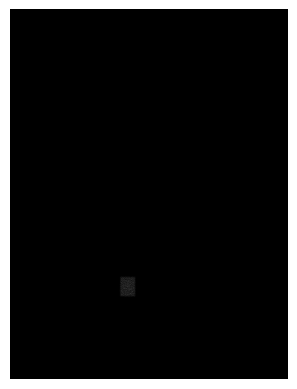

In [114]:
os.makedirs(save_directory, exist_ok=True)
recon_intensity_focal = recon_intensity_np[:,:,int(recon_intensity_np.shape[2]/2)]
recon_intensity_focal_mod = recon_intensity_focal.T
recon_intensity_focal_for_train = zoom(recon_intensity_focal_mod, (1/scaling_factor_y, 1/scaling_factor_x), order=1)
plt.imsave(save_directory+'\\focal_point_intensity_UV.png', recon_intensity_focal_for_train, cmap='gray')
plt.imshow(recon_intensity_focal, cmap="gray")
plt.axis("off")
plt.show()

Export phase mask max = 1023
Export phase mask min = 0


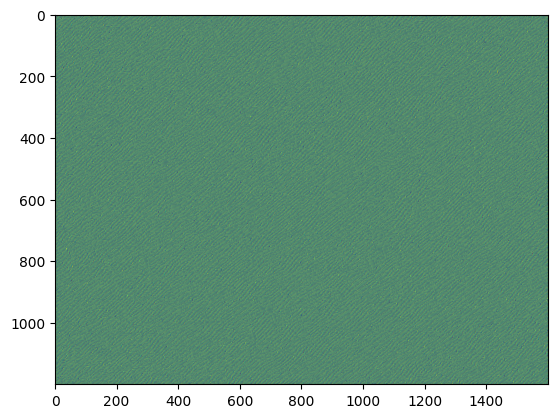

Saved test phase masks at G:\내 드라이브\CITL for 3DHL\2D Images for Generating Phase Mask\square50_offset_aironly_obp_phase_mask


In [115]:
phase_mask_test = phase%(2*torch.pi)
phase_mask_test *= 1023/(2*torch.pi)
phase_mask_test = torch.round(phase_mask_test).to(torch.int16)
phase_mask_test = phase_mask_test.T
print(f'Export phase mask max = {phase_mask_test.max()}')
print(f'Export phase mask min = {phase_mask_test.min()}')

#Display masks
fig, ax = plt.subplots(1,1)
ax.imshow(phase_mask_test.cpu().detach().numpy())
plt.savefig(save_directory+'\phase_mask_uv.png', dpi=150)
plt.show()


if not os.path.isdir(save_directory):
    os.makedirs(save_directory)
    print(f'Creating saving directory at {save_directory}')

np.save(os.path.join(save_directory,'phase_mask_uv.npy'), phase_mask_test.cpu().detach().numpy())

print(f'Saved test phase masks at {save_directory}')